In [47]:
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pandas as pd
import sys
import inspect
import datetime
from scipy.stats import percentileofscore
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
sys.path.append(parentdir + '/modeling')
import load_data
from fit_and_predict import add_preds
from functions import merge_data
from viz import  viz_interactive
import numpy as np
import pandas as pd
from os.path import join as oj
import os
import pandas as pd
import sys
import matplotlib as plt
from scipy.stats import percentileofscore

# CHANGE THIS
from exponential_modeling import *
from fit_and_predict import *

In [5]:
# Load in the Data

print('loading data...')
NUM_DAYS_LIST = [1, 2, 3, 4, 5, 6, 7]
df_county = load_data.load_county_level(data_dir=oj(parentdir, 'data'))

#df_county = add_preds(df_county, NUM_DAYS_LIST=NUM_DAYS_LIST,
#                          cached_dir=oj(parentdir, 'data'))

loading data...
loading county-level data...
loaded and merged COVID-19 cases/deaths data successfully


In [339]:
df_hos

,CountyName,Date,hospitalizations,countyFIPS
0,Los Angeles,4/1/2020,739.0,06037
1,San Bernardino,4/1/2020,95.0,06071
2,Orange,4/1/2020,117.0,06059
3,Riverside,4/1/2020,85.0,06065
4,Sacramento,4/1/2020,53.0,06067
...,...,...,...,...
3298,Tuolumne,05/26/2020,0.0,06109
3299,Unassigned,05/26/2020,0.0,0
3300,Ventura,05/26/2020,34.0,06111
3301,Yolo,05/26/2020,1.0,06113


In [514]:
df_hos = pd.read_csv("../data/CA_hospitalizations.csv")
df_hos = df_hos[["County Name", "Most Recent Date", "COVID-19 Positive Patients"]]
df_hos = df_hos.rename(columns={"County Name": "CountyName", "Most Recent Date": "Date", 
                               "COVID-19 Positive Patients": "hospitalizations"})

In [515]:
# Merge the Data
fips = df_county[df_county["StateName"] == "CA"][["countyFIPS", "CountyName"]]
df_hos = df_hos.merge(fips, on="CountyName", how="left")
df_hos = df_hos.fillna(0)

In [516]:
df_CA = df_hos[["countyFIPS", "CountyName"]].drop_duplicates()
df_CA = df_CA[df_CA["CountyName"] != "Unassigned"]
hospitz = []
for county in df_CA["CountyName"]:
    # Generate the Series
    arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values
    hospitz.append(np.concatenate(([0], arr))) # Adding 0 since there seems to be an issue if we don't
#     hospitz.append(np.concatenate(([], arr))) # Adding 0 since there seems to be an issue if we don't

# Append
df_CA["hospitalizations"] = hospitz

In [282]:
preds = linear_fit(df_CA["hospitalizations"].values, mode="eval_mode")

In [540]:
# Exponential Fit
length = len(df_hos[df_hos["CountyName"] == "Los Angeles"]["hospitalizations"].values)
preds = []
k = 5
for i in range(k,length):
    hospitz = []
    for county in df_CA["CountyName"]:
        # Generate the Series
        arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values[:i]
        hospitz.append(np.concatenate(([0], arr)))
        
#         hospitz.append(np.concatenate(([], arr)))

    # Append
    df_CA["hospitalizations"] = hospitz
    
    
    preds.append(exponential_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([k])))
#     preds.append(linear_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([1])))
    
preds= np.array(preds)[:, :, 0].T
preds = preds[:, 1:] # Drop the first 0s

In [541]:
#### Linear Fit
length = len(df_hos[df_hos["CountyName"] == "Los Angeles"]["hospitalizations"].values)
preds_linear = []
for i in range(4 + k,length):
    hospitz = []
    for county in df_CA["CountyName"]:
        # Generate the Series
        arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values[:i]
        hospitz.append(np.concatenate(([0], arr))) 
        # Note: Concatenating 1 to avoid issue with 0's and linear fit

    # Append
    df_CA["hospitalizations"] = hospitz
    
    
#     preds.append(exponential_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([1])))
    preds_linear.append(linear_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([k])))
    
preds_linear= np.array(preds_linear)[:, :, 0].T
preds_linear = preds_linear[:, 1:] # Drop the first 0s

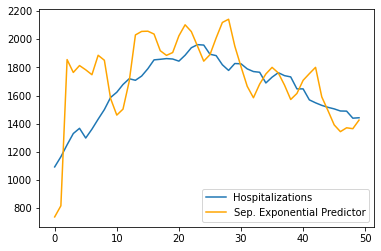

In [542]:
# Let's Plot LA Exponential
LA = df_CA["hospitalizations"][0][k:-1]
preds_LA = preds[0, :]
t = range(max(len(LA), len(preds_LA)))
plt.plot(t, LA, label="Hospitalizations")
plt.plot(t, preds_LA, color="orange", label="Sep. Exponential Predictor")
plt.legend()

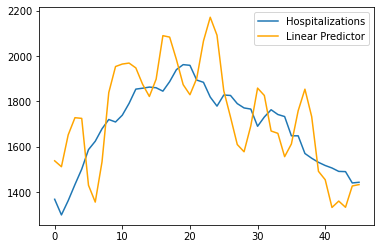

In [543]:
# Let's Plot LA Linear
LA = df_CA["hospitalizations"][0][4 + k:-1]
preds_LA = preds_linear[0, :]
t = range(len(LA))
t_lin = range(len(preds_LA))
plt.plot(t, LA, label="Hospitalizations")
plt.plot(t_lin, preds_LA, color="orange", label="Linear Predictor")
plt.legend()
plt.show()

# Shared Model

In [547]:
# Does plugging in what we've done above just work?
# preds = fit_and_predict_shared_exponential(df_CA, outcome="hospitalizations", mode="eval_mode")

# Shared Exponential Fit
length = len(df_hos[df_hos["CountyName"] == "Los Angeles"]["hospitalizations"].values)
preds_shared = []
k = 5
# Start at 2 for 1 day prediction
for i in range(1 + k,length):
    hospitz = []
    for county in df_CA["CountyName"]:
        # Generate the Series
        arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values[:i]
        hospitz.append(np.concatenate(([0], arr)))

    # Append
    df_CA["hospitalizations"] = hospitz
    
    # predict_future
    preds_shared.append(fit_and_predict_shared_exponential(df_CA, outcome="hospitalizations",
                                 mode="eval_mode", target_day=np.array([k])))
    
#     preds.append(linear_fit(df_CA["hospitalizations"].values, mode="eval_mode", target_day=np.array([1])))
    
preds_shared= np.array(preds_shared)[:, :, 0].T
preds_shared = preds_shared[:, 1:] # Drop the first 0s 

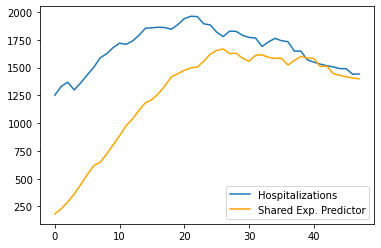

In [549]:
# Let's Plot LA Shared Exponential
LA = df_CA["hospitalizations"][0][1 + k:-1]
preds_LA = preds_shared[0, :] - 1
t = range(max(len(LA), len(preds_LA)))
plt.plot(t, LA, label="Hospitalizations")
plt.plot(t, preds_LA, color="orange", label="Shared Exp. Predictor")
plt.legend()

In [268]:
# Just note how this works
tmp = create_shared_simple_dataset(df_CA, outcome="hospitalizations",days_to_subtract=1)
# fit_and_predict_shared_exponential(df_CA, outcome="hospitalizations",
#                                  mode="eval_mode", target_day=np.array([1]))

# Imputing Deaths with CLEP

In [550]:
# Calculate df_CA
# 1/22/2020 to 4/1/2020 is 70 days
k = 5
shifted_date = 70
cen = 4
df_CA_county = df_county[df_county['StateName'].isin(['CA'])]

# Compute the Imputed Deaths
# lin_impu_future_predictions = []
# exp_impu_future_predictions = []
# shared_impu_exp_future_predictions = []
## Censoring the UCSF_data

LA_data = df_CA["hospitalizations"][0]
# LA_cen = LA_data[cen:]
imputed_deaths = []

## Q: Should beginning of the range be 0 or the start_day?
## Q: Should we include this k? 
## A: I hate time series...
for i in range(1,LA_data.shape[0]-k + 1): 
    df_CA_test = df_CA_county.copy(deep=True)
    # Calculate the Imputed Deaths
    for county in range(len(df_CA_test)):
            # do we need to remove columns and truncate counts??
            # truncate list counts: deaths, cases, neighbor_deaths, neighbor_cases
            for col in ['deaths', 'cases', 'neighbor_deaths', 'neighbor_cases']:
                # adding 1 to predict t
                df_CA_test[col].iloc[county] = df_CA_test[col].iloc[county][:shifted_date + i] 
    
    tmp = fit_and_predict_ensemble(df_CA_test, target_day=np.array([k]))
#     sf_dop = tmp[tmp["CountyName"] == "San Francisco"]

    # Formatting Fix
    imputed_deaths.append(np.array([x[0] for x in tmp["predicted_deaths_ensemble_" + str(k)].values]))
    

imputed_deaths = np.array(imputed_deaths)
imputed_deaths = imputed_deaths.T

In [472]:
x = [np.array([1]), np.array([2]), np.array([3])]
y = [x_0[0] for x_0 in x]
y

[1, 2, 3]

In [471]:
x

[[1], [2], [3]]

In [551]:
preds_shared_imputed = []
start_day = 5
for i in range(start_day,LA_data.shape[0]-k + 1): 
    df_shared_CA = df_CA.copy(deep=True)
        
    hospitz = []
    im_arr = []
    for county in df_CA["CountyName"]:
        # Generate the Series
        arr = df_hos[df_hos["CountyName"] == county]["hospitalizations"].values[:i]
        hospitz.append(arr)
        
    for county in range(len(df_CA["CountyName"])):
        # Generate the Series
        im_deaths = imputed_deaths[county, :i]
        im_arr.append(im_deaths)  
        
    assert len(hospitz[0]) == len(im_arr[0]) 

    # Append
    df_shared_CA["hospitalizations"] = hospitz
    df_shared_CA["imputed_deaths"] = im_arr
    
    
    
    # Feature Transforms
    feat_transforms = {}
    feat_transforms["hospitalizations"] = [lambda x: np.log(x+1)]
    feat_transforms["imputed_deaths"] = [lambda x: np.log(x + 1)]
    
    # Auxiliary Time Variables
    aux_vars = ["imputed_deaths"]
    
    # Time Series Default Values
    default_values = defaultdict(lambda: 0) 
    
    # Run the Shared Model
    shared_model = SharedModel(df_shared_CA,mode = "predict_future",
                                                            outcome = "hospitalizations",
                                                            demographic_variables=[],
                                                            auxiliary_time_features=aux_vars,
                                                            target_days=np.array([k]), 
                                                            feat_transforms=feat_transforms,
                                                            time_series_default_values = default_values,
                                                            scale=False)
    
    
    shared_model.create_dataset()
    shared_model.fit_model()
    shared_model.predict()
    
    preds_shared_imputed.append(shared_model.predictions)
    
preds_shared_imputed = np.array(preds_shared_imputed)[:, :, 0].T

/home/ubuntu/anaconda3/lib/python3.6/site-packages/statsmodels/base/elastic_net.py:332: RuntimeWarning:

invalid value encountered in double_scalars



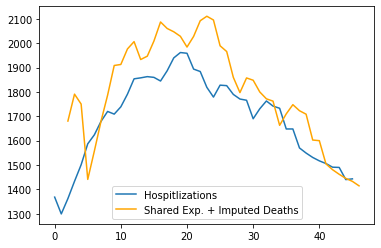

In [552]:
# Let's Plot LA Shared Exponential
LA = df_CA["hospitalizations"][0][start_day + k - 1:-1]
preds_LA = preds_shared_imputed[0, :] 
t_LA = range(0, len(LA))
t_preds = np.array(range(0, len(preds_LA))) #+ len(t_LA) -len(t_preds) + 2
plt.plot(t_LA, LA, label="Hospitlizations")
plt.plot(t_preds, preds_LA, color="orange", label="Shared Exp. + Imputed Deaths")
plt.legend()

In [495]:
t_LA

range(0, 51)

In [494]:
t_preds

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
       23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52])

7

In [455]:
np.array(preds_shared_imputed).shape

(58, 52)

# Ensemble Model

In [ ]:
use_df = exponential_modeling.leave_t_day_out(df, target_day[-1])


weights = pmdl_weight.compute_pmdl_weight(use_df, 
                                          methods=methods, 
                                          outcome=outcome,
                                          target_day=target_day)
sum_weights = np.zeros(len(use_df))
for model_index in weights:
    sum_weights = sum_weights + np.array(weights[model_index])

#weighted_preds = np.zeros((len(use_df), len(target_day)))
weighted_preds = [np.zeros(len(target_day)) for i in range(len(use_df))]
for i in range(len(df)):
    for model_index in weights:
        weighted_preds[i] += np.array(predictions[model_index][i]) * weights[model_index][i] / sum_weights[i]


## Let's Do Some Plotting

In [ ]:
## This is a Lie, it isn't UCSF Data
LA_data = df_CA["hospitalizations"][0][1 + k:-1]

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

axs[0, 0].plot(UCSF_data[start_day+k-1:],'r',label = "UCSF hospitalization data")
axs[0, 0].plot(lin_future_predictions,'b',label= "Linear predictions")
axs[0, 0].set_title('Linear')
axs[0, 0].set_ylim([0, 50])

axs[0, 1].plot(UCSF_data[start_day+k-1:],'r',label = "UCSF hospitalization data")
axs[0, 1].plot(exp_future_predictions,'b',label= "Separate exp predictions")
axs[0, 1].set_title('Separate Exp')

axs[1, 0].plot(UCSF_data[start_day+k-1:],'r',label = "UCSF hospitalization data")
axs[1, 0].plot(shared_exp_future_predictions,'b',label= "Shared exp predictions")
axs[1, 0].set_title('Shared Exp')

axs[1, 1].plot(np.arange(4, len(UCSF_data[start_day+k-1:])), UCSF_cen[start_day+k-1:],'r',label = "UCSF hospitalization data")
axs[1, 1].plot(np.arange(4, len(UCSF_data[start_day+k-1:])), np.array(preds),'b',label= "Imputed deaths shared exp predictions")
axs[1, 1].set_title('Imputed deaths')

for ax in axs.flat:
    ax.set(xlabel='# days since 3/28/20', ylabel='# hospitalizations')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

fig.suptitle(str(k)+"-day ahead prediction for shared exponential predictor")
plt.savefig("UCSF_Hospitalizations_plots/combinedplot_"+str(k)+".jpg", dpi=150)